In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-rna-3d-folding/sample_submission.csv
/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv
/kaggle/input/stanford-rna-3d-folding/test_sequences.csv
/kaggle/input/stanford-rna-3d-folding/validation_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_labels.csv
/kaggle/input/stanford-rna-3d-folding/train_sequences.csv


In [39]:
import polars as pl
import torch
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Upload the data

In [15]:
def load_data(source) -> pl.DataFrame:
    return pl.read_csv(source = source, truncate_ragged_lines = True)

In [16]:
#Load the data
train_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/train_sequences.csv")
train_labels = load_data(source = "/kaggle/input/stanford-rna-3d-folding/train_labels.csv")
test_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/test_sequences.csv")
valid_sequences = load_data(source = "/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv")
valid_labels = load_data(source = "/kaggle/input/stanford-rna-3d-folding/validation_labels.csv")
sample_submission = load_data(source = "/kaggle/input/stanford-rna-3d-folding/sample_submission.csv")

#Check for N/A
datasets = {
    "Train Sequences": train_sequences,
    "Train Labels": train_labels,
    "Test Sequences": test_sequences,
    "Validation Sequences": valid_sequences,
    "Validation Labels": valid_labels,
}

for name, df in datasets.items():
    null_counts = df.null_count().sum()
    print(f"N/A count for {name}: {null_counts}")

N/A count for Train Sequences: shape: (1, 5)
┌───────────┬──────────┬─────────────────┬─────────────┬───────────────┐
│ target_id ┆ sequence ┆ temporal_cutoff ┆ description ┆ all_sequences │
│ ---       ┆ ---      ┆ ---             ┆ ---         ┆ ---           │
│ u32       ┆ u32      ┆ u32             ┆ u32         ┆ u32           │
╞═══════════╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 0         ┆ 0        ┆ 0               ┆ 0           ┆ 5             │
└───────────┴──────────┴─────────────────┴─────────────┴───────────────┘
N/A count for Train Labels: shape: (1, 6)
┌─────┬─────────┬───────┬──────┬──────┬──────┐
│ ID  ┆ resname ┆ resid ┆ x_1  ┆ y_1  ┆ z_1  │
│ --- ┆ ---     ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u32 ┆ u32     ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞═════╪═════════╪═══════╪══════╪══════╪══════╡
│ 0   ┆ 0       ┆ 0     ┆ 6145 ┆ 6145 ┆ 6145 │
└─────┴─────────┴───────┴──────┴──────┴──────┘
N/A count for Test Sequences: shape: (1, 5)
┌───────────┬──────────┬─────

In [17]:
# Fill the N/A with 0 
train_sequences.fill_null(0)
train_labels.fill_null(0)

ID,resname,resid,x_1,y_1,z_1
str,str,i64,f64,f64,f64
"""1SCL_A_1""","""G""",1,13.76,-25.974001,0.102
"""1SCL_A_2""","""G""",2,9.31,-29.638,2.669
"""1SCL_A_3""","""G""",3,5.529,-27.813,5.878
"""1SCL_A_4""","""U""",4,2.678,-24.900999,9.793
"""1SCL_A_5""","""G""",5,1.827,-20.136,11.793
…,…,…,…,…,…
"""8Z1F_T_82""","""U""",82,0.0,0.0,0.0
"""8Z1F_T_83""","""C""",83,0.0,0.0,0.0
"""8Z1F_T_84""","""A""",84,0.0,0.0,0.0


In [21]:
class RNADataset(Dataset):
    def __init__(self, sequences: pl.DataFrame, labels: pl.DataFrame = None):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        self.sequences.shape[0]

    def __getitem__(self, idx):
        sequence = self.sequences[idx].to_dict()
        label = self.labels[idx].to_dict() if self.labels is not None else None
        return sequence, label

#Create a DataLoader
batch_size = 32
train_dataset = RNADataset(train_sequences, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size)

## Visualize

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<function matplotlib.pyplot.show(close=None, block=None)>

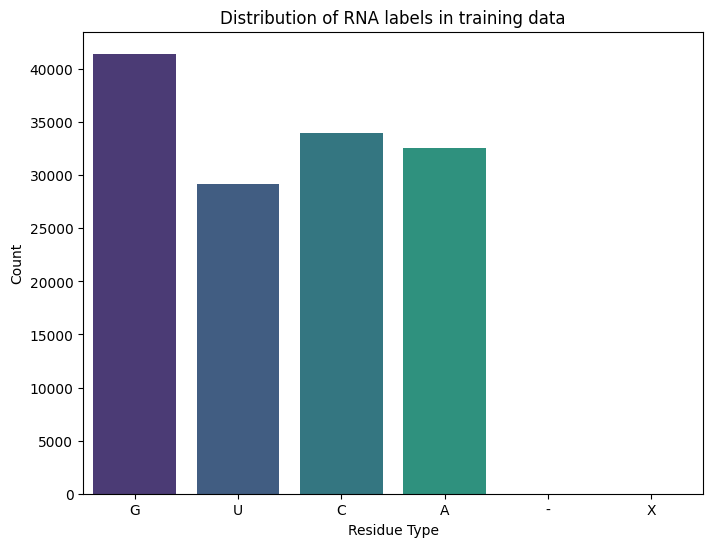

In [30]:
#Visualization of residue type
plt.figure(figsize = (8, 6))
sns.countplot(x = train_labels['resname'].to_list(), palette = "viridis")
plt.xlabel("Residue Type")
plt.ylabel("Count")
plt.title("Distribution of RNA labels in training data")
plt.show

<ipython-input-40-9879943affa2>:25: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 7  # Default is 10, lower values zoom in, higher values zoom out


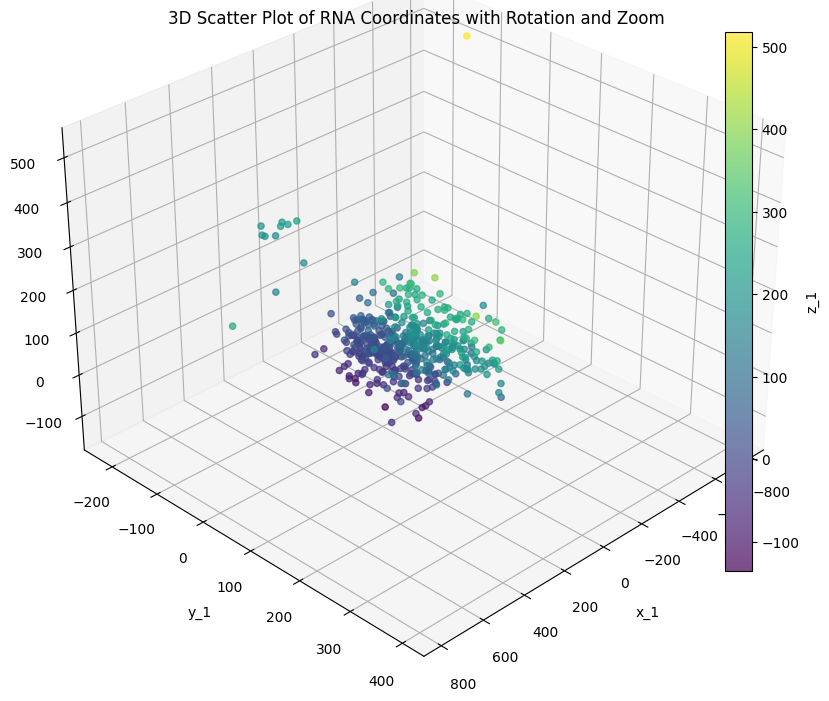

In [40]:
#Visualization of 3D coordinates
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Sample data and filter out invalid rows
sample_data = train_labels.sample(500).to_dict(as_series=False)

# Extract and validate coordinates
x = np.array(sample_data['x_1'], dtype=float)
y = np.array(sample_data['y_1'], dtype=float)
z = np.array(sample_data['z_1'], dtype=float)

# Create scatter plot
sc = ax.scatter(x, y, z, c=z, cmap='viridis', alpha=0.7)
plt.colorbar(sc, ax=ax, label='z_1')

# Set labels and title
ax.set_xlabel('x_1')
ax.set_ylabel('y_1')
ax.set_zlabel('z_1')
plt.title('3D Scatter Plot of RNA Coordinates with Rotation and Zoom')

# Set rotation (elevation, azimuth) and zoom
ax.view_init(elev=30, azim=45)  # Change elev and azim to set the initial rotation
ax.dist = 7  # Default is 10, lower values zoom in, higher values zoom out

# Enable interactive mode
plt.ion()
plt.show()